In [2]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
import seaborn as sns
sns.set_theme(color_codes=True)
from scipy import stats
import statsmodels.api as sm
import numpy as np
from tqdm import tqdm_notebook 
import statsmodels.formula.api as smf


/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read the Data

In [3]:
first_session_raw_data = pd.read_csv('Data/gono-go-game-first-round.csv', index_col=0).reset_index()
# first_session_raw_data = first_session_raw_data[first_session_raw_data['recorded_at'] > '2022-01-18']

num_all_experimenters = len(first_session_raw_data.mturkID.unique())
num_excluded_experimenters = 0

first_session_raw_data['correct'] = first_session_raw_data.correct == 'true'
# first_session_raw_data.head()

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (32,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Apply exclusion criteria

1. Fail the quiz of instructions more than twice.
2. Change the tab or window of the experiment.

In [4]:
first_session_clean_data = first_session_raw_data[(first_session_raw_data.exp_final_status == 'fully_completed')]

num_excluded_experimenters = len(first_session_raw_data.mturkID.unique()) - len(first_session_clean_data.mturkID.unique())

print("Number of participants excluded by this criterias:", num_excluded_experimenters)

Number of participants excluded by this criterias: 31


3. Respond randomly, always go or never go.

    * Note: We exclude who repond randomly, always go or nogo in each 3 block

In [5]:
susp = first_session_clean_data[first_session_clean_data.suspicious == 'true'][['mturkID', 'suspicious_type','num_gos', 'block']]

In [6]:
IDs_for_exclusion_by_random_response = []
IDs_for_exclusion_by_random_response = list(susp.mturkID.value_counts()[ (susp.mturkID.value_counts() == 3) ].index)



num_excluded_experimenters += len(IDs_for_exclusion_by_random_response)

first_session_clean_data = first_session_clean_data[first_session_clean_data.mturkID.isin(IDs_for_exclusion_by_random_response) == False]

print("Number of participants excluded by this criterias:", len(IDs_for_exclusion_by_random_response))


Number of participants excluded by this criterias: 12


4. Their rate of the correct response to detection of circle side task is less than 55%.

In [7]:
circle_side_correctness = first_session_clean_data[first_session_clean_data.choice == 'go'][['mturkID','side', 'response']]
circle_side_correctness['is_correct_circle_side'] =  (circle_side_correctness.side == circle_side_correctness.response)
accuracy_data = circle_side_correctness.groupby('mturkID').mean().reset_index()
accuracy_data.columns = ['mturkID', 'rate']
accuracy_data['is_below_55'] = accuracy_data.rate < 0.55


In [8]:
non_accurate_IDs = accuracy_data[accuracy_data.is_below_55].mturkID

num_excluded_experimenters += len(non_accurate_IDs)

first_session_clean_data = first_session_clean_data[first_session_clean_data.mturkID.isin(list(non_accurate_IDs)) == False]
print("Number of participants excluded by this criterias:", len(non_accurate_IDs))



Number of participants excluded by this criterias: 44


In [9]:
len(first_session_clean_data.mturkID.unique())

146

In [10]:
first_session_clean_data.columns

Index(['run_id', 'condition', 'rt', 'url', 'trial_type', 'trial_index',
       'time_elapsed', 'internal_node_id', 'experiment_id', 'assignmentID',
       'mturkID', 'hitID', 'exp_final_status', 'success', 'timeout',
       'failed_images', 'failed_audio', 'failed_video', 'stimulus', 'response',
       'exp_stage', 'view_history', 'exp_part', 'question_order', 'quiz_score',
       'recorded_at', 'ip', 'user_agent', 'device', 'browser',
       'browser_version', 'platform', 'platform_version',
       'source_code_version', 'focus_screen', 'color', 'cond', 'cond_action',
       'cond_outcome', 'block', 'side', 'x_circle', 'y_circle', 'choice',
       'correct', 'curr_bonus', 'trial_bonus', 'outcome', 'feedback_points',
       'prob_fall', 'expected_feedback', 'agg_fb_pts', 'error_block',
       'num_gos', 'num_nogos', 'suspicious', 'hitId', 'workerId',
       'assignmentId', 'a', 'tp_a', 'b', 'tp_b', 'c', 'tp_c',
       'suspicious_type'],
      dtype='object')

# Plot Perforance per conditions

/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_6576/1667143160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)


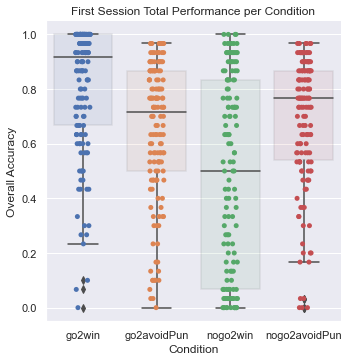

In [11]:
mapping = {'1': 'go2win', '2': 'nogo2win', '3': 'go2avoidPun', '4' : 'nogo2avoidPun'} 

circle_task_logs = first_session_clean_data[first_session_clean_data.exp_stage == 'main_target_detection']

circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)
performance_per_condition = circle_task_logs.groupby(['mturkID','cond']).mean().reset_index()
performance_per_condition.cond = performance_per_condition.cond.map(mapping)

ax = sns.catplot(x="cond", y="correct", data=performance_per_condition, order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);
ax = sns.boxplot(x="cond", y="correct", data= performance_per_condition , boxprops=dict(alpha=.1), order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);

ax.set(xlabel="Condition", ylabel = "Overall Accuracy", title = 'First Session Total Performance per Condition')
plt.show()


# NoGO 2 Win Performance Dist.

<AxesSubplot:ylabel='Frequency'>

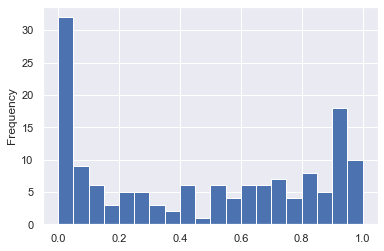

In [11]:
performance_per_condition[performance_per_condition.cond == 'nogo2win'].correct.plot(kind='hist', bins = 20)

In [12]:
circle_task_logs['cond'] = circle_task_logs.cond_action + '2' + circle_task_logs.cond_outcome 
GOs = (circle_task_logs[circle_task_logs.choice == 'go'].groupby(['mturkID']).count()['run_id'].rename('first_num_GOs'))
noGos = (circle_task_logs[circle_task_logs.choice == 'nogo'].groupby(['mturkID']).count()['run_id'].rename('first_num_noGos'))
go2win_Gos = (circle_task_logs[(circle_task_logs.choice == 'go') & (circle_task_logs.cond == 'go2win')].groupby(['mturkID']).count()['run_id'].rename('first_num_go2win_Gos'))
nogo2avoidpun_noGos = (circle_task_logs[(circle_task_logs.choice == 'nogo') & (circle_task_logs.cond == 'nogo2avoidPun')].groupby(['mturkID']).count()['run_id'].rename('first_num_nogo2avoidPun_noGos'))
new_pav_metric_df = pd.concat([GOs, noGos, go2win_Gos, nogo2avoidpun_noGos], axis=1)
# new_pav_metric_df

/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_24716/3973988031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circle_task_logs['cond'] = circle_task_logs.cond_action + '2' + circle_task_logs.cond_outcome


# Extract demographic data

In [117]:
raw_demographic_data = first_session_clean_data[first_session_clean_data.trial_type == 'survey-html-form'][['mturkID', 'response']]
# raw_demographic_data = first_session_raw_data[first_session_raw_data.trial_type == 'survey-html-form'][['mturkID', 'response']]

raw_demographic_data['gender'] = raw_demographic_data.response.apply(lambda x: x.split('"')[3])
raw_demographic_data['age'] = raw_demographic_data.response.apply(lambda x: x.split('"')[7])
raw_demographic_data['education_level'] = raw_demographic_data.response.apply(lambda x: x.split('"')[11])
raw_demographic_data['comments'] = raw_demographic_data.response.apply(lambda x: x.split('"')[15])
raw_demographic_data = raw_demographic_data.drop(['response'], axis=1)
raw_demographic_data.head()

,mturkID,gender,age,education_level,comments
1770,A353XKDTUX10NC,male,27,High,}
2577,A2NAKIXS3DVGAA,male,27,Bachelor,}
4200,A320QA9HJFUOZO,male,34,Bachelor,"Everything worked fine, thanks."
5007,AI4AO0O0WIJF7,female,46,High,}
6624,AKNYT1NTK2UFK,other,37,Bachelor,}


In [119]:
raw_demographic_data.shape

(146, 5)

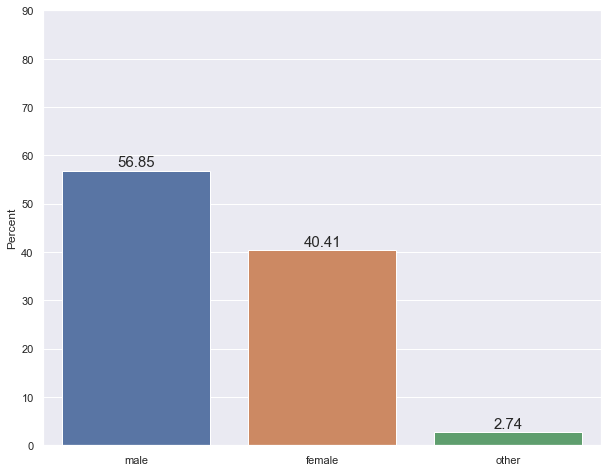

In [120]:
plt.figure(figsize=(10,8))
plt.ylabel("Percent")
gender_percent = (raw_demographic_data.gender.value_counts(normalize=True))*100
gender_percent[0]
ax = sns.barplot(y = gender_percent,x = gender_percent.index)
ax.set_yticks(np.arange(0, 100, 10));
ax.set_ylabel("Percent");

for bar in ax.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()

In [122]:
sum_age = []
for i in (raw_demographic_data.age):
    try:
        sum_age.append(int(i))
    except:
        print("ERRRR")

In [124]:
np.mean(sum_age)

39.57534246575342

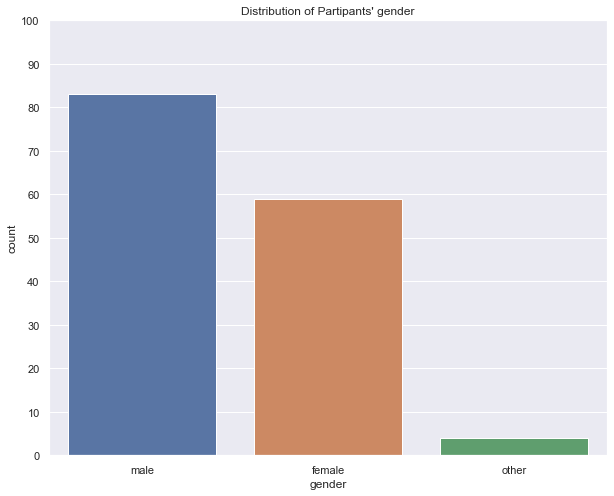

In [38]:
plt.figure(figsize=(10,8))
plt.title("Distribution of Partipants' gender"  )
# plt.xlabel('Number of Axles')
# plt.ylabel('Frequency [%]')
ax = sns.countplot(data= raw_demographic_data, x ='gender')
ax.set_yticks(np.arange(0, 110, 10))

# Create final data to analyze

In [14]:
final_performace_data = performance_per_condition.pivot(index='mturkID', columns='cond', values='correct').reset_index()

final_performace_data = pd.merge(final_performace_data, accuracy_data, on='mturkID', how='left')
final_performace_data = pd.merge(final_performace_data, raw_demographic_data, on='mturkID')
final_performace_data.columns = ['mturkID', 'go2avoidPun_first_session', 'go2win_first_session', 'nogo2avoidPun_first_session', 'nogo2win_first_session', 'circle_side_performance_first_session',\
       'is_below_55_first_session', 'gender_first_session', 'age_first_session', 'education_level_first_session', 'comments_first_session']
overall_performance =  final_performace_data['nogo2win_first_session'] + \
                        final_performace_data['go2win_first_session'] + \
                        final_performace_data['nogo2avoidPun_first_session'] + \
                        final_performace_data['go2avoidPun_first_session']


final_performace_data['overall_performance'] = overall_performance/4

final_performace_data = final_performace_data.merge(new_pav_metric_df, on='mturkID', how='left')

final_performace_data.head()

,mturkID,go2avoidPun_first_session,go2win_first_session,nogo2avoidPun_first_session,nogo2win_first_session,circle_side_performance_first_session,is_below_55_first_session,gender_first_session,age_first_session,education_level_first_session,comments_first_session,overall_performance,first_num_GOs,first_num_noGos,first_num_go2win_Gos,first_num_nogo2avoidPun_noGos
0,A10BH9PYCYUKDJ,0.100000,1.000000,0.833333,0.300000,0.983871,False,female,41,Associate,None,0.558333,59,61,30.0,25.0
1,A10JXOU89D5RXR,0.800000,1.000000,0.833333,0.000000,1.000000,False,female,60,Bachelor,none,0.658333,89,31,30.0,25.0
2,A10M63DSIGIEDI,0.466667,0.633333,0.000000,0.033333,0.610687,False,male,25,Bachelor,None,0.283333,119,1,30.0,NaN
3,A11S8IAAVDXCUS,0.733333,1.000000,0.966667,0.033333,1.000000,False,female,31,Associate,},0.683333,82,38,30.0,29.0
4,A12FTSX85NQ8N9,0.566667,0.500000,0.866667,0.866667,0.895833,False,male,29,Bachelor,},0.700000,42,78,16.0,26.0


In [15]:
# final_performace_data.first_num_GOs

In [16]:
final_performace_data.to_csv('Data/first_round_final_performance.csv')

# Pavlovian Axis 
### learned individualas are those who their OVERALL PERFORMANCE > 0.65

(0.0, 1.0)

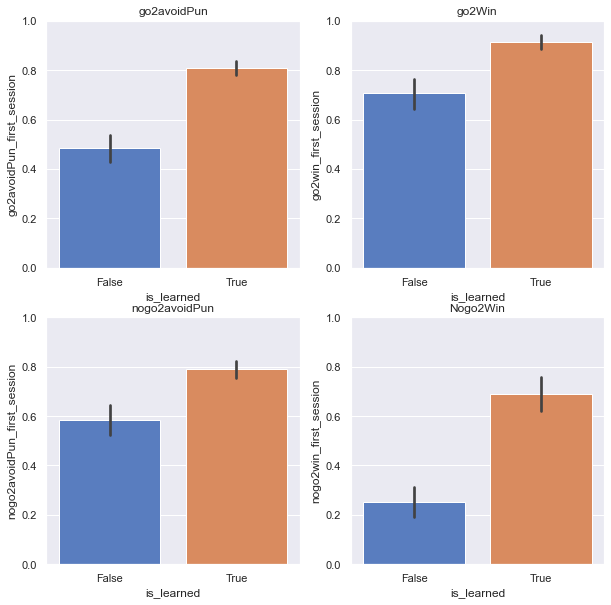

In [17]:
fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(10,10))
plt.ylim(0, 1)

final_performace_data['is_learned'] = final_performace_data.overall_performance > 0.65

sns.barplot(x="is_learned", y="nogo2win_first_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(1,1)]).set_title('Nogo2Win')

axs[1,1].set_ylim(0,1)

sns.barplot(x="is_learned", y="go2win_first_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(0,1)]).set_title('go2Win')
axs[0,1].set_ylim(0,1)



sns.barplot(x="is_learned", y="go2avoidPun_first_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(0,0)]).set_title('go2avoidPun')
axs[0,0].set_ylim(0,1)



sns.barplot(x="is_learned", y="nogo2avoidPun_first_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(1,0)]).set_title('nogo2avoidPun')
axs[1,0].set_ylim(0,1)




# Modelling

In [18]:
result_of_trials = circle_task_logs[['mturkID', 'internal_node_id', 'response', 'side', 'choice', 'cond_action', 'cond_outcome','correct_action', 'outcome', 'feedback_points', 'block']].copy()

result_of_trials['stimulus'] = result_of_trials['cond_action'] + '2' + result_of_trials['cond_outcome']
result_of_trials['is_go'] = result_of_trials.choice == 'go'
result_of_trials['is_go'].replace({True: 1, False: 0}, inplace=True)


In [19]:
result_of_trials[['mturkID','choice', 'feedback_points', 'stimulus']].to_csv('data_for_modeling_matlab_first_session.csv')


In [20]:
result_of_trials.mturkID.unique().shape

(146,)

In [21]:
go2win_go_prob = pd.Series(np.zeros(30))
go2win_prob_df = pd.DataFrame()

nogo2win_go_prob = pd.Series(np.zeros(30))
nogo2win_prob_df = pd.DataFrame()

go2avoidPun_go_prob = pd.Series(np.zeros(30))
go2avoidPun_prob_df = pd.DataFrame()

nogo2avoidPun_go_prob = pd.Series(np.zeros(30))
nogo2avoidPun_prob_df = pd.DataFrame()




for mID in result_of_trials.mturkID.dropna().unique():
    go_of_every_subject = result_of_trials[result_of_trials['mturkID']== mID][['is_go','stimulus']].reset_index(drop=True)
    for s in ['go2win','nogo2win','go2avoidPun', 'nogo2avoidPun']:
        go_of_every_subject_in_s = go_of_every_subject[go_of_every_subject.stimulus == s].reset_index(drop=True)
        if( s == 'go2win'):
            go2win_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            go2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'nogo2win'):
            nogo2win_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            nogo2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'go2avoidPun'):
            go2avoidPun_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            go2avoidPun_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'nogo2avoidPun'):
            nogo2avoidPun_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            nogo2avoidPun_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()


/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_24716/3190507868.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  go2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_24716/3190507868.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  nogo2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_24716/3190507868.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

In [22]:
go_prob_df = pd.DataFrame({'go2win': go2win_go_prob, 
                            'nogo2win': nogo2win_go_prob,
                            'go2avoidPun': go2avoidPun_go_prob,\
                            'nogo2avoidPun': nogo2avoidPun_go_prob})

# go_prob_df['idx'] = go_prob_df.index

go_prob_df = go_prob_df.melt().rename(columns={'variable': 'stimulus', 'value': 'go_prob'})


In [23]:
go_prob_df.loc[go_prob_df.stimulus == 'go2win', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'nogo2win', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'go2avoidPun', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'nogo2avoidPun', 'idx'] = range(0,30)
 

(0.0, 1.0)

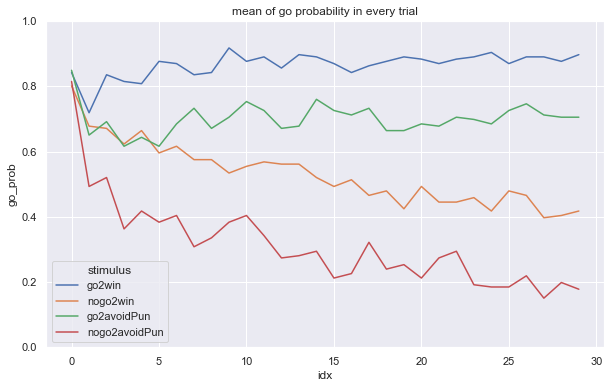

In [24]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="idx", y="go_prob",
             hue="stimulus", 
             data=go_prob_df)
plt.title("mean of go probability in every trial")
plt.ylim(0,1)


# modeling procedure

In [25]:
from sys import path
from dotenv import load_dotenv
import os
load_dotenv();

path.append(os.environ.get("MODELING_PATH"))

from fitting import ML



In [26]:
np.random.seed(30)
modeling_result_df = {}
modeling_result_df['mturkID'] = []

modeling_result_df['alpha'] = []
modeling_result_df['beta'] = []
modeling_result_df['noise'] = []
modeling_result_df['go_bias'] = []
modeling_result_df['pav_bias'] = []


def fit_subject_with_id(subject_id):
    df = result_of_trials[result_of_trials.mturkID == subject_id]
    df = df[['choice','stimulus','feedback_points']].rename(columns={'choice':'action', 'feedback_points':'reward'}).reset_index(drop=True)
    df['reward'] = pd.to_numeric(df.reward)
    df['ID'] = subject_id

    max_likelihood = ML(df, optimization_method='L-BFGS-B', model_type='RW+noise+bias+Pav')
    res = max_likelihood.fit_EM_alg(iterations=1)
    return res



In [27]:
# from joblib import Parallel, delayed



# results = Parallel(n_jobs=5)(delayed(fit_subject_with_id)(subject) for subject in result_of_trials.mturkID.unique()
# )
# print(results)





# for subject in tqdm_notebook(result_of_trials.mturkID.unique()):
#     res = fit_subject_with_id(subject)

    # modeling_result_df['mturkID'].append(subject)
    # modeling_result_df['alpha'].append(1 / (1+ np.exp(-res.x[0])))
    # modeling_result_df['beta'].append(np.exp(res.x[1]))
    # modeling_result_df['noise'].append(1 / (1+ np.exp(-res.x[2])))
    # modeling_result_df['go_bias'].append(res.x[3])
    # modeling_result_df['pav_bias'].append(np.exp(res.x[4]))




In [28]:
result_of_modeling = []
for r in results:
    result_of_modeling.append(pd.DataFrame(r))

result_of_modeling_df = pd.concat(result_of_modeling, axis=0)

NameError: name 'results' is not defined

In [50]:
result_of_modeling_df['alpha'] = result_of_modeling_df['alpha'].astype('float')
result_of_modeling_df['beta'] = result_of_modeling_df['beta'].astype('float')

NameError: name 'result_of_modeling_df' is not defined

In [51]:
result_of_modeling_df['alpha'] = 1/(1+ np.exp(-result_of_modeling_df['alpha']))
result_of_modeling_df['beta'] = np.exp(result_of_modeling_df['beta'])
result_of_modeling_df['noise'] = 1/(1+ np.exp(-result_of_modeling_df['noise']))
result_of_modeling_df['pav'] = np.exp(result_of_modeling_df['pav'])


NameError: name 'result_of_modeling_df' is not defined

In [52]:
result_of_modeling_df.to_csv('result_of_modeling_df.csv')

NameError: name 'result_of_modeling_df' is not defined

In [53]:
mr_df = pd.read_csv("result_of_modeling_matlab_first_session.csv")
# mr_df.columns = ['mturkID', 'alpha', 'beta', 'noise', 'bias', 'pav']

In [54]:
# mr_df = pd.DataFrame(modeling_result_df)
# mr_df['pav_bias_log'] = np.log(mr_df.pav_bias)

In [55]:
# mr_df.to_csv('./Data/modeling_result_first_session.csv')

In [56]:
mr_df

,mturkID,alpha,beta,noise,bias,pav
0,A10BH9PYCYUKDJ,0.032798,8.745182,0.977425,0.111071,2.074325
1,A10JXOU89D5RXR,0.739849,9.161395,0.949481,3.194171,0.621218
2,A10M63DSIGIEDI,0.090104,1.148812,0.983119,3.916653,0.201712
3,A11S8IAAVDXCUS,0.333036,48.601867,0.985864,1.305883,0.350864
4,A12FTSX85NQ8N9,0.443714,2.131303,0.970367,-0.874009,0.282252
5,A12HZGOZQD5YK7,0.084375,15.948646,0.979196,0.697673,0.513962
6,A12X8RUSITV7RU,0.202412,8.652663,0.978818,0.866448,0.075777
7,A136K4YZY2OFTV,0.081973,7.690878,0.977199,1.552180,0.339103
8,A14LOABUGAITBM,0.313335,0.877786,0.960540,1.368025,0.153189
9,A14W0AXTJ3R19V,0.132035,1.701321,0.973552,1.738087,0.436034


# dist of log(pav bias)

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pav', ylabel='Density'>

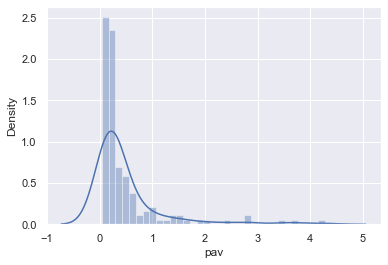

In [57]:
sns.distplot((mr_df.pav) )

# dist of learning rate

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='alpha', ylabel='Density'>

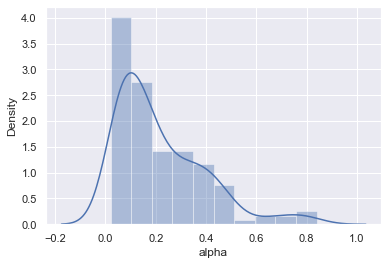

In [58]:
sns.distplot((mr_df.alpha), bins=10) 

# dist of go bias

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bias', ylabel='Density'>

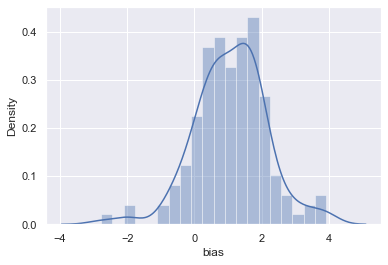

In [59]:
sns.distplot((mr_df.bias), bins=20) 

# dist of log(sensitivity to reward)

<AxesSubplot:xlabel='noise', ylabel='Count'>

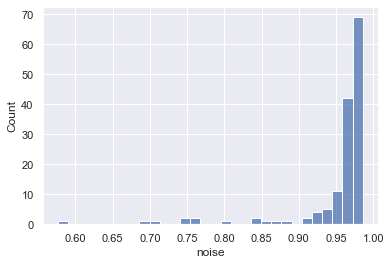

In [60]:
sns.histplot(((mr_df.noise)), bins=30) 

In [61]:
mr_df.columns

Index(['mturkID', 'alpha', 'beta', 'noise', 'bias', 'pav'], dtype='object')

In [62]:
mr_perf = pd.merge(mr_df, final_performace_data, on='mturkID')


mr_perf['gw_ngw'] = mr_perf.go2win_first_session - mr_perf.nogo2win_first_session

mr_perf['non_par_pav'] = mr_perf.go2win_first_session + mr_perf.nogo2avoidPun_first_session - mr_perf.nogo2win_first_session - mr_perf.go2avoidPun_first_session

mr_perf['non_par_go_bias']  = mr_perf.go2win_first_session + mr_perf.go2avoidPun_first_session - mr_perf.nogo2win_first_session - mr_perf.nogo2avoidPun_first_session
# mr_perf = mr_perf[(np.log(mr_perf.pav_bias) > -20) & (np.log(mr_perf.pav_bias) < 20)]

In [63]:
mr_perf

,mturkID,alpha,beta,noise,bias,pav,go2avoidPun_first_session,go2win_first_session,nogo2avoidPun_first_session,nogo2win_first_session,circle_side_performance_first_session,is_below_55_first_session,gender_first_session,age_first_session,education_level_first_session,comments_first_session,overall_performance,first_num_GOs,first_num_noGos,first_num_go2win_Gos,first_num_nogo2avoidPun_noGos,is_learned,gw_ngw,non_par_pav,non_par_go_bias
0,A10BH9PYCYUKDJ,0.032798,8.745182,0.977425,0.111071,2.074325,0.100000,1.000000,0.833333,0.300000,0.983871,False,female,41,Associate,None,0.558333,59,61,30.0,25.0,False,0.700000,1.433333e+00,-3.333333e-02
1,A10JXOU89D5RXR,0.739849,9.161395,0.949481,3.194171,0.621218,0.800000,1.000000,0.833333,0.000000,1.000000,False,female,60,Bachelor,none,0.658333,89,31,30.0,25.0,True,1.000000,1.033333e+00,9.666667e-01
2,A10M63DSIGIEDI,0.090104,1.148812,0.983119,3.916653,0.201712,0.466667,0.633333,0.000000,0.033333,0.610687,False,male,25,Bachelor,None,0.283333,119,1,30.0,NaN,False,0.600000,1.333333e-01,1.066667e+00
3,A11S8IAAVDXCUS,0.333036,48.601867,0.985864,1.305883,0.350864,0.733333,1.000000,0.966667,0.033333,1.000000,False,female,31,Associate,},0.683333,82,38,30.0,29.0,True,0.966667,1.200000e+00,7.333333e-01
4,A12FTSX85NQ8N9,0.443714,2.131303,0.970367,-0.874009,0.282252,0.566667,0.500000,0.866667,0.866667,0.895833,False,male,29,Bachelor,},0.700000,42,78,16.0,26.0,True,-0.366667,-6.666667e-02,-6.666667e-01
5,A12HZGOZQD5YK7,0.084375,15.948646,0.979196,0.697673,0.513962,0.700000,0.900000,0.833333,0.033333,1.000000,False,female,41,Associate,},0.616667,82,38,27.0,25.0,False,0.866667,1.000000e+00,7.333333e-01
6,A12X8RUSITV7RU,0.202412,8.652663,0.978818,0.866448,0.075777,0.800000,1.000000,0.833333,0.600000,1.000000,False,female,27,Bachelor,},0.808333,71,49,30.0,25.0,True,0.400000,4.333333e-01,3.666667e-01
7,A136K4YZY2OFTV,0.081973,7.690878,0.977199,1.552180,0.339103,0.766667,1.000000,0.566667,0.033333,0.990566,False,male,52,Bachelor,Nothing to add.,0.591667,95,25,30.0,17.0,False,0.966667,7.666667e-01,1.166667e+00
8,A14LOABUGAITBM,0.313335,0.877786,0.960540,1.368025,0.153189,0.500000,0.566667,0.200000,0.266667,0.686275,False,female,26,Bachelor,none,0.383333,92,28,24.0,6.0,False,0.300000,-5.551115e-17,6.000000e-01
9,A14W0AXTJ3R19V,0.132035,1.701321,0.973552,1.738087,0.436034,0.566667,0.966667,0.300000,0.033333,0.836364,False,female,32,Bachelor,},0.466667,101,19,30.0,9.0,False,0.933333,6.666667e-01,1.200000e+00


<AxesSubplot:xlabel='bias', ylabel='gw_ngw'>

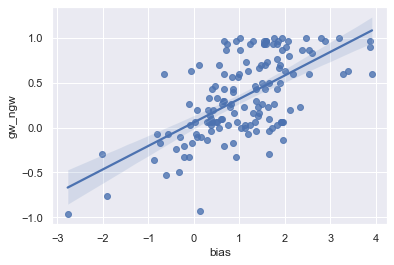

In [64]:
sns.regplot(x=('bias'), y='gw_ngw', data = mr_perf)



In [65]:
smf.ols(formula = 'bias ~ non_par_go_bias', data = mr_perf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   bias   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     204.4
Date:                Mon, 28 Feb 2022   Prob (F-statistic):           2.05e-29
Time:                        11:55:59   Log-Likelihood:                -151.89
No. Observations:                 146   AIC:                             307.8
Df Residuals:                     144   BIC:                             313.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6475      0.065     10.009      0.000       0.520       0.775
non_par_go_bias     1.4611      0.102     14.295      0.000       1.259       1.663
==============================================================================
Omnibus:                        0.929   Durbin-Watson:                   2.181
Prob(Omnibus):                  0.628   Jarque-Bera (JB):                1.040
Skew:                           0.144   Prob(JB):                        0.594
Kurtosis:                       2.704   Cond. No.                         2.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# log(pav bias) & (g2win - nogo2win) performance 

<AxesSubplot:xlabel='pav', ylabel='non_par_pav'>

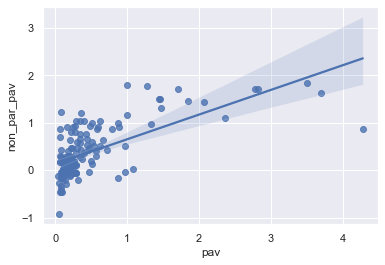

In [66]:
sns.regplot(x=('pav'), y='non_par_pav', data = mr_perf[mr_perf.pav < 10])



In [67]:
smf.ols(formula = 'non_par_pav ~ pav', data = mr_perf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            non_par_pav   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     112.5
Date:                Mon, 28 Feb 2022   Prob (F-statistic):           8.91e-20
Time:                        11:56:08   Log-Likelihood:                -76.428
No. Observations:                 146   AIC:                             156.9
Df Residuals:                     144   BIC:                             162.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1317      0.041      3.179      0.002       0.050       0.214
pav            0.5199      0.049     10.605      0.000       0.423       0.617
==============================================================================
Omnibus:                        4.592   Durbin-Watson:                   2.373
Prob(Omnibus):                  0.101   Jarque-Bera (JB):                5.578
Skew:                           0.146   Prob(JB):                       0.0615
Kurtosis:                       3.912   Cond. No.                         1.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
huber_t = sm.RLM(mr_perf.pav, sm.add_constant(mr_perf.non_par_pav), M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(
    hub_results.summary(
#         yname="y", xname=["var_%d" % i for i in range(len(hub_results.params))]
    )
)

                    Robust linear Model Regression Results                    
Dep. Variable:                    pav   No. Observations:                  146
Model:                            RLM   Df Residuals:                      144
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 27 Feb 2022                                         
Time:                        22:15:08                                         
No. Iterations:                    37                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1735      0.023      7.687      

In [38]:
import statsmodels.api as sm

import statsmodels.formula.api as smf

In [51]:
smf.ols(formula = 'non_par_pav ~ pav', data = mr_perf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            non_par_pav   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     112.5
Date:                Sun, 27 Feb 2022   Prob (F-statistic):           8.91e-20
Time:                        22:13:53   Log-Likelihood:                -76.428
No. Observations:                 146   AIC:                             156.9
Df Residuals:                     144   BIC:                             162.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1317      0.041      3.179      0.002       0.050       0.214
pav            0.5199      0.049     10.605      0.000       0.423       0.617
==============================================================================
Omnibus:                        4.592   Durbin-Watson:                   2.373
Prob(Omnibus):                  0.101   Jarque-Bera (JB):                5.578
Skew:                           0.146   Prob(JB):                       0.0615
Kurtosis:                       3.912   Cond. No.                         1.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# learning rate & (g2win - nogo2win) performance 

<AxesSubplot:xlabel='alpha', ylabel='gw_ngw'>

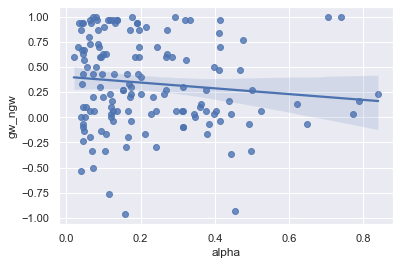

In [59]:
sns.regplot(x=(mr_perf['alpha']), y=mr_perf['gw_ngw'])

In [41]:
smf.ols(formula = 'gw_ngw ~ alpha', data = mr_perf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 gw_ngw   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.875
Date:                Sun, 27 Feb 2022   Prob (F-statistic):              0.173
Time:                        22:08:45   Log-Likelihood:                -87.976
No. Observations:                 146   AIC:                             180.0
Df Residuals:                     144   BIC:                             185.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4026      0.059      6.856      0.000       0.287       0.519
alpha         -0.2870      0.210     -1.369      0.173      -0.701       0.127
==============================================================================
Omnibus:                        2.543   Durbin-Watson:                   2.196
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                2.580
Skew:                          -0.289   Prob(JB):                        0.275
Kurtosis:                       2.701   Cond. No.                         5.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""